In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.ensemble import RandomForestClassifier



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


##### Accessing the New York WCB Insurance dataset:

In [4]:
import os
pwd = os.getcwd()
file_loc = os.path.join(pwd, 'gdrive/MyDrive/IS733 Project/insurance_dataset.csv')

link = 'https://drive.google.com/file/d/1rz2GtkcmUFLfXwbPh9bWQ3BWV15X5fIp/view?usp=share_link'

In [5]:
! gdown 1rz2GtkcmUFLfXwbPh9bWQ3BWV15X5fIp

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1rz2GtkcmUFLfXwbPh9bWQ3BWV15X5fIp 



In [6]:
df = pd.read_csv(file_loc)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22,23,33,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##### Checking structure of dataset:

In [7]:
df.shape

(4570786, 54)

##### Viewing at the attributes of the Dataset:

In [8]:
df.columns.to_list()
# list(df.columns)
# initial_list = list(df.columns)
# initial_list

['Accident',
 'Accident Date',
 'Age at Injury',
 'Alternative Dispute Resolution',
 'ANCR Date',
 'Assembly Date',
 'Attorney/Representative',
 'Average Weekly Wage',
 'Birth Year',
 'C-2 Date',
 'C-3 Date',
 'Carrier Name',
 'Carrier Type',
 'Claim Identifier',
 'Claim Injury Type',
 'Claim Type',
 'Closed Count',
 'Controverted Date',
 'County of Injury',
 'COVID-19 Indicator',
 'Current Claim Status',
 'District Name',
 'First Appeal Date',
 'First Hearing Date',
 'Gender',
 'Hearing Count',
 'Highest Process',
 'IME-4 Count',
 'Industry Code',
 'Industry Code Description',
 'Interval Assembled to ANCR',
 'Medical Fee Region',
 'Occupational Disease',
 'OIICS Event Exposure Code',
 'OIICS Event Exposure Description',
 'OIICS Injury Source Code',
 'OIICS Injury Source Description',
 'OIICS Nature of Injury Code',
 'OIICS Nature of Injury Description',
 'OIICS Part Of Body Code',
 'OIICS Part Of Body Description',
 'OIICS Secondary Source Code',
 'OIICS Secondary Source Description',

##### Calculating the level of missingness and presenting as a DataFrame in descending order:

In [9]:
missing_data_num = (df.isnull().sum()/len(df))*100
missing_data_num = missing_data_num.drop(missing_data_num[missing_data_num == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Level of Missingness(%)' : missing_data_num})
missing_data

,Level of Missingness(%)
PTD Date,99.886890
PPD Non-Scheduled Loss Date,97.690944
First Appeal Date,96.443850
Section 32 Date,94.516304
Controverted Date,90.403926
PPD Scheduled Loss Date,88.260137
OIICS Secondary Source Description,75.014669
OIICS Secondary Source Code,75.014669
OIICS Injury Source Code,75.013947
OIICS Injury Source Description,75.013947


Now checking the Birth year distribution of captured workers:

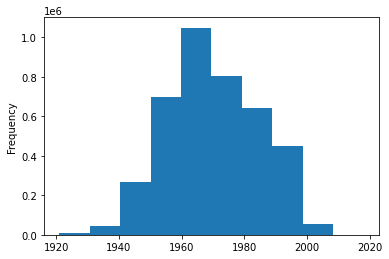

In [10]:
df[df['Birth Year'] > 1920]['Birth Year'].plot.hist()

The above distribution is a Gaussian distribution and truly representative.

##### From the accident data, we see that the level of missingness (40881) is relatively small. As a result, we would drop the corresponding rows

In [11]:
df['Accident Date'].value_counts()

09/11/2001    12530
03/01/2020     1761
03/15/2017     1552
03/09/2015     1524
12/03/2019     1375
              ...  
08/20/1976        1
04/30/1980        1
02/16/1955        1
09/06/1992        1
06/15/1991        1
Name: Accident Date, Length: 13645, dtype: int64

###** NOTABLE EVENTS GOING BY THE ABOVE ACCIDENT DATE COUNTS:**
1. 09/11/2001: Following the tragic incident at the World Trade Center
2. 03/01/2020: Gov. Cuomo (the then governor of NewYork State) announced the first cases of COVID-19 

In [12]:
df['Accident Date'].isna().sum()

40881

In [13]:
df = df.dropna(subset=['Accident Date'])

In [14]:
(df['Accident Date'] == 0).sum()

0

Since we are exploring Worker's compensation-related data, workers will definitely be on paid jobs. Therefore, we will consider zero Average Weekly Wages as not valid for this analysis. We will proceed to drop the associated rows:

In [15]:
df['Average Weekly Wage'].isna().sum()

0

In [16]:
df.drop(df[df['Average Weekly Wage'] == 0].index, inplace = True)

In [17]:
df['Average Weekly Wage'].isna().sum()

0

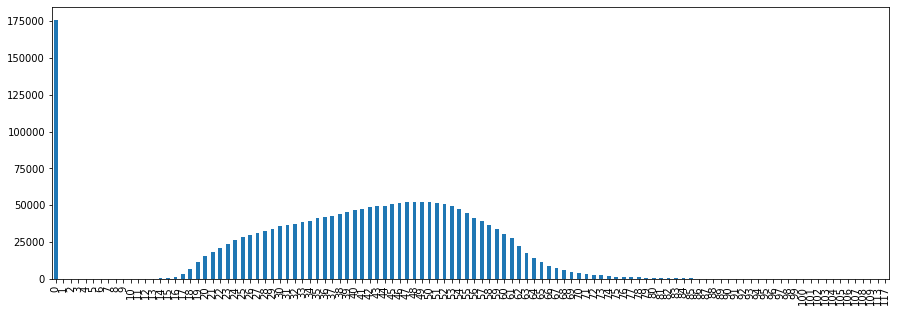

In [18]:
df[(df['Age at Injury'] >= 0) & (df['Age at Injury'] <= 175)]['Age at Injury'].value_counts().sort_index().plot.bar(figsize=(15,5))

The 0 value ages are obviously missing values. Moving on to Age of Injury, ideal ages to be explored include Ages between 16 and 75. Trimming to this Age of Injury window:

In [19]:
df.drop(df[df['Age at Injury'] < 16].index, inplace=True)
df.drop(df[df['Age at Injury'] > 75].index, inplace=True)


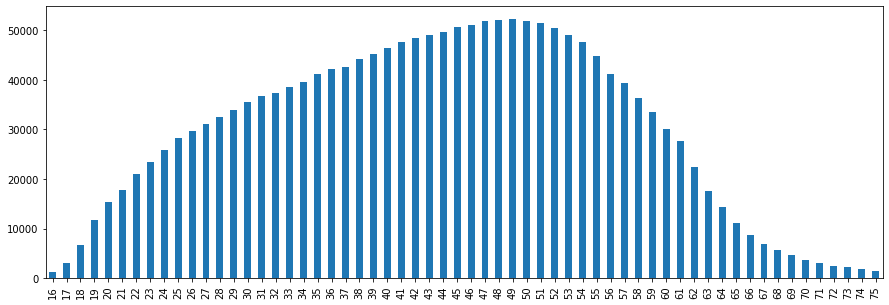

In [20]:
df[(df['Age at Injury'] >= 0) & (df['Age at Injury'] <= 175)]['Age at Injury'].value_counts().sort_index().plot.bar(figsize=(15,5))

In [21]:
df['Average Weekly Wage'].isna().sum()

0

In [22]:
(df['Average Weekly Wage'] == 0).sum()

0

Using Domain Knowledge and Level of missingness, the original dataset will now be trimmed to 15 features by dropping the columns outrightly:

In [23]:
df = df.drop(columns = ['WCIO Cause of Injury Description', 'C-2 Date', 'C-3 Date', 'Interval Assembled to ANCR','Industry Code Description', 'First Hearing Date', 'Accident', 'Birth Year', 'Carrier Name', 'Claim Identifier', 'Claim Type', 'ANCR Date', 'Controverted Date', 'County of Injury', 'COVID-19 Indicator', 'First Appeal Date', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'OIICS Event Exposure Code', 'OIICS Event Exposure Description', 'OIICS Injury Source Code', 'OIICS Injury Source Description', 'OIICS Nature of Injury Code', 'OIICS Nature of Injury Description', 'OIICS Part Of Body Code', 'OIICS Part Of Body Description', 'OIICS Secondary Source Code', 'OIICS Secondary Source Description', 'PPD Non-Scheduled Loss Date', 'PPD Scheduled Loss Date', 'PTD Date', 'Section 32 Date', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Description', 'WCIO Part Of Body Code', 'Zip Code'], axis = 1 )

###### to check missing values in claim_df dataframe

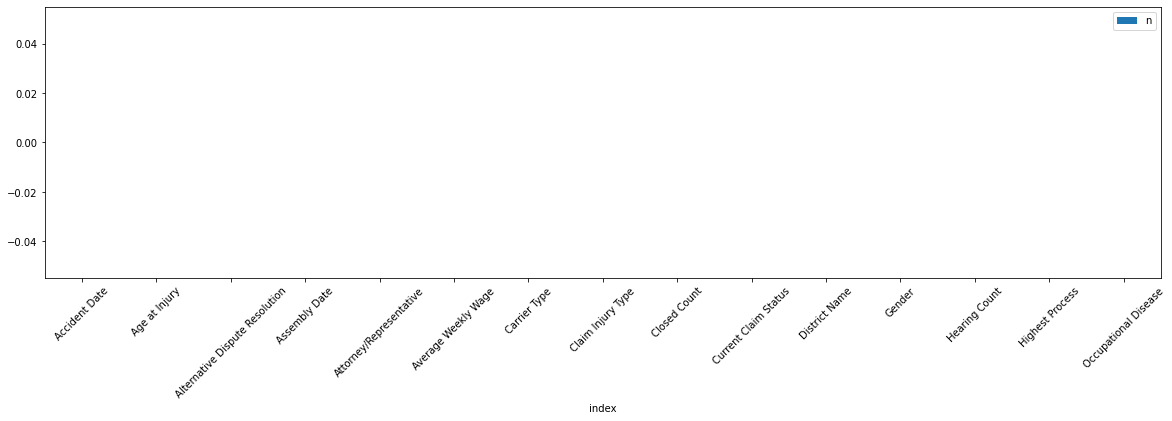

In [24]:
df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=45, figsize=(20,5))

In [25]:
# df.to_csv("insurance_data_clean4viz2.csv", index=False)

##### Accident Date precedes Assembly Date (the date the claim was first assembled. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker). We will proceed to extract a new feature which will be termed "Claim Assembly Time Lag", a positive difference between the two dates:

In [26]:
import datetime
df['Accident Date Transformed'] = pd.to_datetime(df['Accident Date'])
df['Assembly Date Transformed'] = pd.to_datetime(df['Assembly Date'])
df['Claim Assembly Time Lag'] =  df['Assembly Date Transformed'] - df['Accident Date Transformed']


##### Dropping the former columns: 

In [27]:
df.drop(columns = [ 'Accident Date Transformed', 'Accident Date', 'Assembly Date', 'Assembly Date Transformed'], inplace=True, axis = 1 )

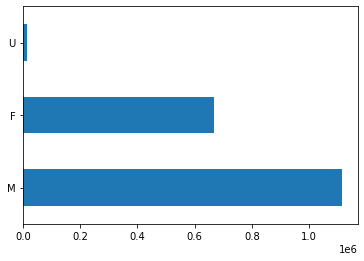

In [28]:
df['Gender'].value_counts().plot.barh()

##### For a better and more acute analysis, the 'Undefined' Gender will be dropped:

In [29]:
df.drop(df[df['Gender'] == 'U'].index, inplace=True)

In [30]:
df['Claim Assembly Time Lag']

9909         68 days
16493         6 days
19838        24 days
20487        23 days
20972         4 days
             ...    
4570762     140 days
4570769     204 days
4570774   -2974 days
4570775    -317 days
4570776    -353 days
Name: Claim Assembly Time Lag, Length: 1781313, dtype: timedelta64[ns]

We notice two things. First, the 'days" suffix is not needed. Second, there are negative values which is not right. The difference ought to be positive on every account. We will deal with these two cases

In [31]:
# First issue fix
df['Claim Assembly Time Lag'] = df['Claim Assembly Time Lag'].astype('timedelta64[D]')

##### The number of wrong imputations of Assembly date in the dataset are:

In [32]:
(df['Claim Assembly Time Lag'] < 0).sum()

6967

In [33]:
# Second issue fix
df = df[~(df['Claim Assembly Time Lag'] < 0)]

In [34]:
df['Claim Assembly Time Lag']

9909        68.0
16493        6.0
19838       24.0
20487       23.0
20972        4.0
           ...  
4570759     56.0
4570760    214.0
4570761     27.0
4570762    140.0
4570769    204.0
Name: Claim Assembly Time Lag, Length: 1774346, dtype: float64

In [35]:
(df['Alternative Dispute Resolution'] == "U").sum()

3

Dropping the above 3 outliers:

In [36]:
df.drop(df[df['Alternative Dispute Resolution'] == 'U'].index, inplace=True)

In [37]:
(df['Average Weekly Wage'] < 6).value_counts()

False    1774336
True           7
Name: Average Weekly Wage, dtype: int64

Assuming $1 per day earnings, we will proceed to drop all weekly wages less than 6 dollars:

In [38]:
df.drop(df[df['Average Weekly Wage'] < 6].index, inplace=True)

In [39]:
# df.to_csv("insurance_data_clean4viz3.csv", index=False)

In [40]:
#create copy of current dataset
#feat_df = claim_df.copy()
#claim_df.to_csv('clean1_insurance_data.csv')




In [41]:
#Importing the needed Libraries for this feature selection process (using Chisquare, treating all features as categorical)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [42]:
df.isnull().any().any()

False

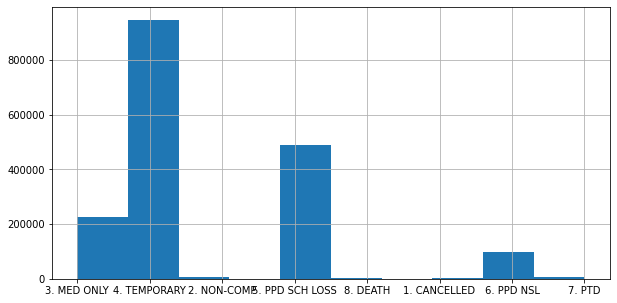

In [43]:
df['Claim Injury Type'].hist(bins=10, figsize=(10,5))

In [44]:
df['Claim Injury Type'].value_counts()

4. TEMPORARY       946358
5. PPD SCH LOSS    488235
3. MED ONLY        224869
6. PPD NSL          98717
2. NON-COMP          6118
7. PTD               4938
8. DEATH             3755
1. CANCELLED         1346
Name: Claim Injury Type, dtype: int64

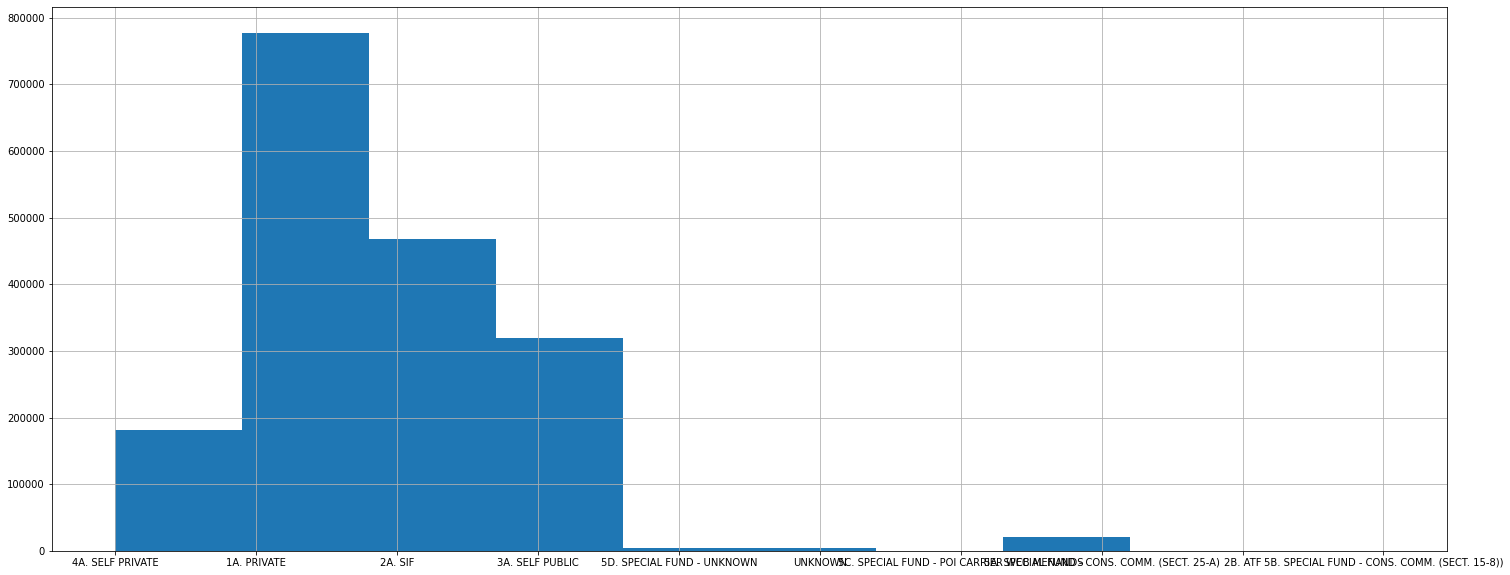

In [45]:
df['Carrier Type'].hist(bins=10, figsize=(25,10))

In [46]:
df['Carrier Type'].value_counts()

1A. PRIVATE                                     777137
2A. SIF                                         467895
3A. SELF PUBLIC                                 319209
4A. SELF PRIVATE                                181782
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)      19985
5D. SPECIAL FUND - UNKNOWN                        4705
UNKNOWN                                           3580
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          30
5B. SPECIAL FUND - CONS. COMM. (SECT. 15-8))         7
2B. ATF                                              6
Name: Carrier Type, dtype: int64

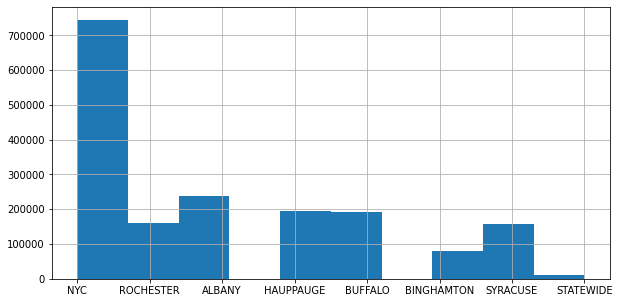

In [47]:
df['District Name'].hist(figsize=(10,5))

In [48]:
df['District Name'].value_counts()

NYC           744245
ALBANY        236628
HAUPPAUGE     193735
BUFFALO       193087
ROCHESTER     159551
SYRACUSE      156594
BINGHAMTON     79549
STATEWIDE      10947
Name: District Name, dtype: int64

In [49]:
df['Current Claim Status'].value_counts()

NO FURTHER ACTION              1711074
MOTION SET                       15975
ADMINISTRATIVELY CLOSED          14437
HEARING UNSET                    11886
HEARING SET                      10671
RE-OPENED ADMINISTRATIVELY        6163
RETURNED TO EXAMINING             2689
CASE CANCELLED                    1346
REFEREE - RESERVED DECISION         89
NEWLY ASSEMBLED                      4
BOARD RESTORAL                       1
ARGUMENT SET                         1
Name: Current Claim Status, dtype: int64

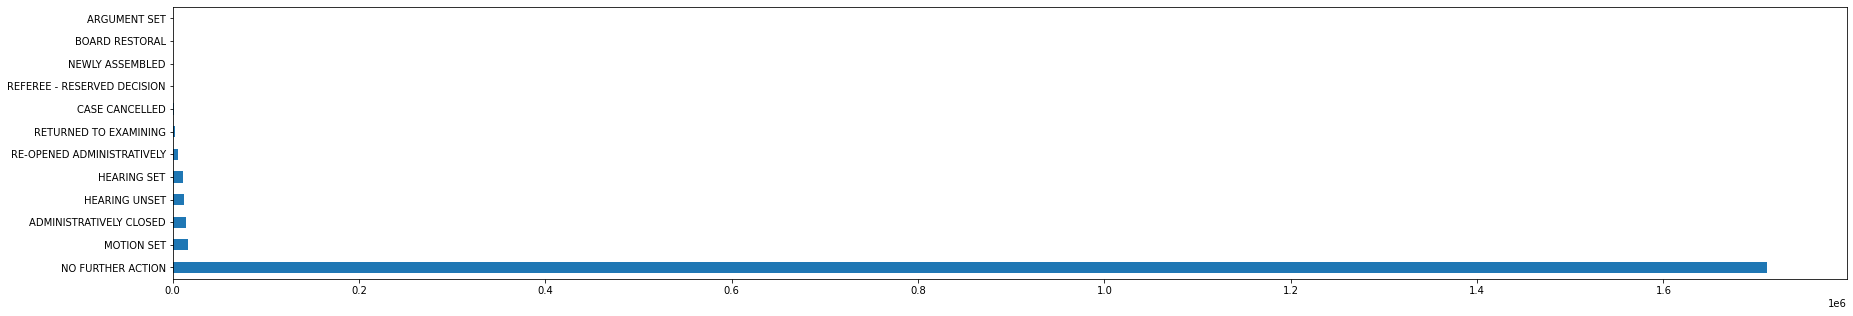

In [50]:
df['Current Claim Status'].value_counts().plot.barh(figsize=(30,5))

In [51]:
median =df['Age at Injury'].median()
median

44.0

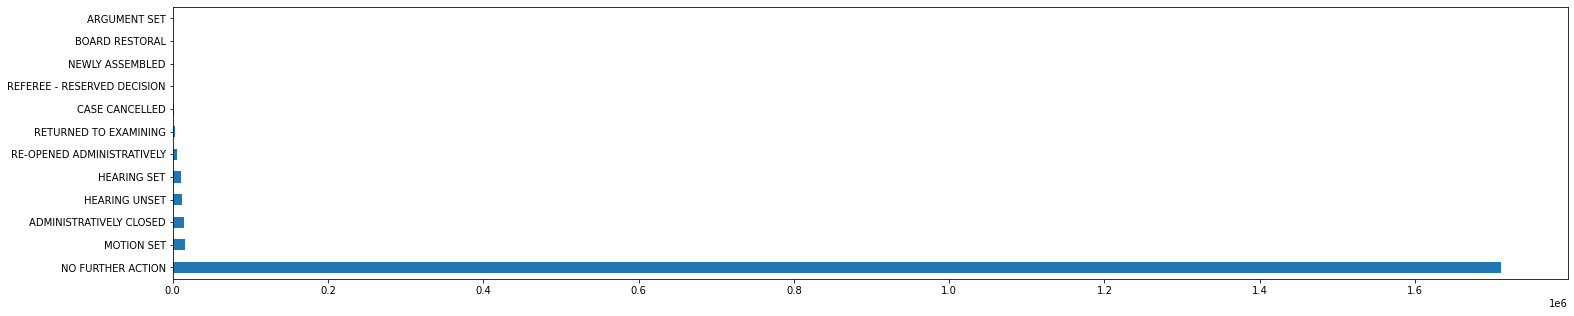

In [52]:
df['Current Claim Status'].value_counts().plot.barh(figsize=(25,5))

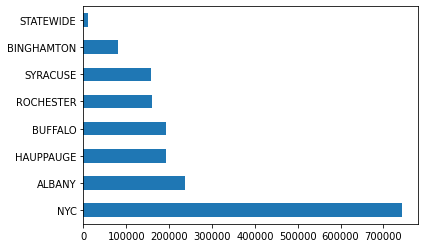

In [53]:
df['District Name'].value_counts().plot.barh()

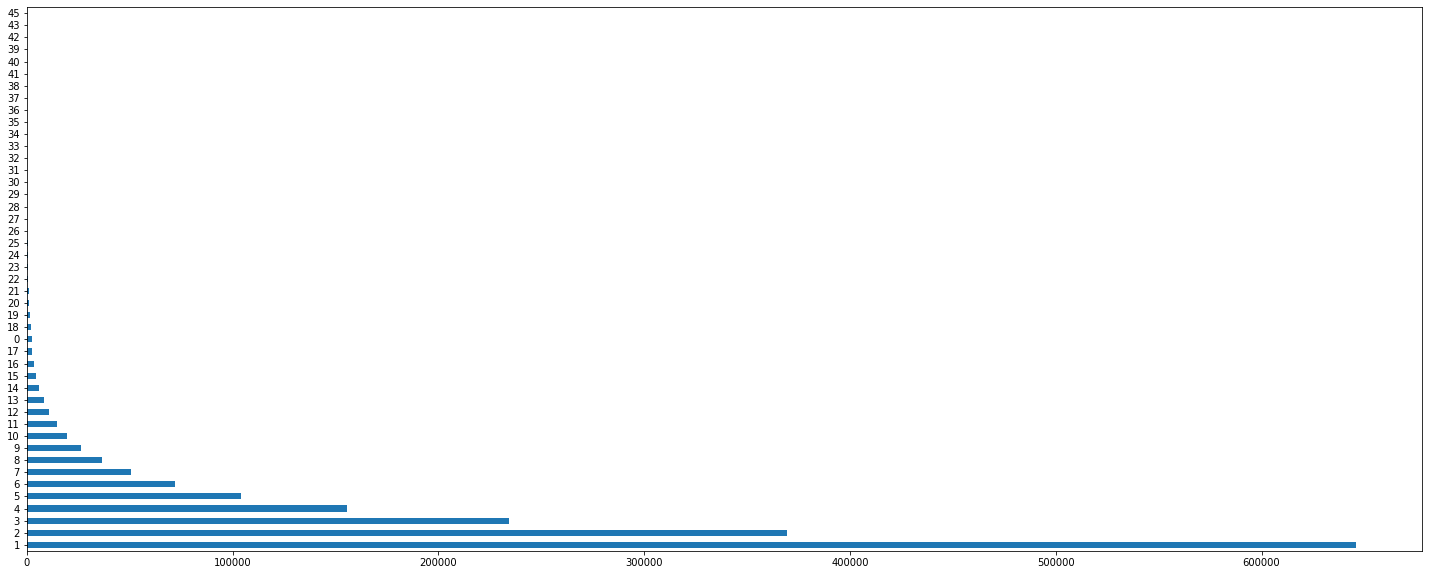

In [54]:
df['Closed Count'].value_counts().plot.barh(figsize=(25,10))

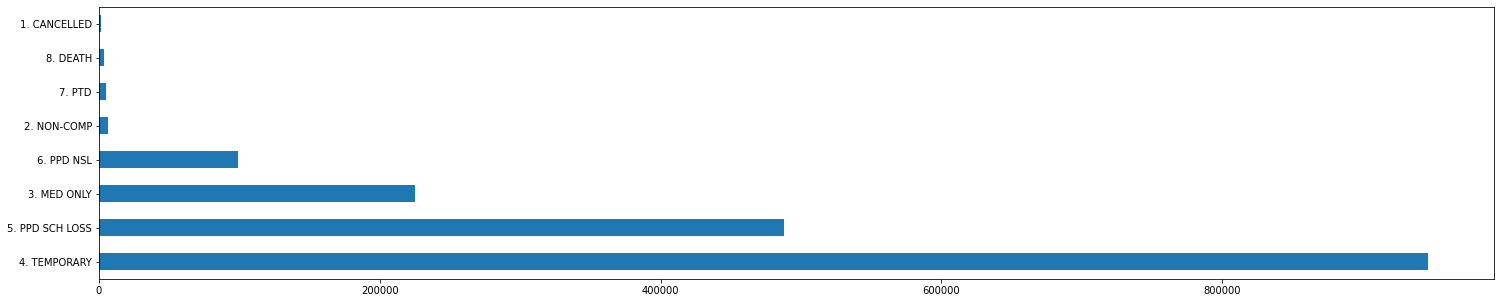

In [55]:
df['Claim Injury Type'].value_counts().plot.barh(figsize=(25,5))

In [56]:
df['Carrier Type'].value_counts()

1A. PRIVATE                                     777137
2A. SIF                                         467895
3A. SELF PUBLIC                                 319209
4A. SELF PRIVATE                                181782
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)      19985
5D. SPECIAL FUND - UNKNOWN                        4705
UNKNOWN                                           3580
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          30
5B. SPECIAL FUND - CONS. COMM. (SECT. 15-8))         7
2B. ATF                                              6
Name: Carrier Type, dtype: int64

##### Viewing the first 20 rows of the cleaned dataset:

In [57]:
df.iloc[0:20, :]

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Carrier Type,Claim Injury Type,Closed Count,Current Claim Status,District Name,Gender,Hearing Count,Highest Process,Occupational Disease,Claim Assembly Time Lag
9909,44,N,Y,546.69,4A. SELF PRIVATE,3. MED ONLY,1,MOTION SET,NYC,M,0,2. ADMINISTRATIVE DETERMINATION,N,68.0
16493,34,N,N,656.23,1A. PRIVATE,4. TEMPORARY,1,MOTION SET,ROCHESTER,M,0,2. ADMINISTRATIVE DETERMINATION,N,6.0
19838,35,N,N,1261.77,1A. PRIVATE,4. TEMPORARY,0,MOTION SET,ALBANY,M,0,2. ADMINISTRATIVE DETERMINATION,N,24.0
20487,25,N,Y,1000.00,2A. SIF,4. TEMPORARY,1,MOTION SET,NYC,M,0,1. NO RESOLUTIONS,N,23.0
20972,48,N,N,1126.77,3A. SELF PUBLIC,3. MED ONLY,1,MOTION SET,HAUPPAUGE,M,0,2. ADMINISTRATIVE DETERMINATION,N,4.0
22145,29,N,Y,1310.52,2A. SIF,4. TEMPORARY,1,MOTION SET,NYC,M,0,1. NO RESOLUTIONS,N,5.0
22320,33,N,N,762.25,1A. PRIVATE,4. TEMPORARY,1,MOTION SET,BUFFALO,M,0,2. ADMINISTRATIVE DETERMINATION,N,11.0
22896,33,N,N,975.00,3A. SELF PUBLIC,3. MED ONLY,1,MOTION SET,HAUPPAUGE,M,0,2. ADMINISTRATIVE DETERMINATION,N,8.0
22951,25,N,N,880.90,1A. PRIVATE,3. MED ONLY,1,MOTION SET,BUFFALO,M,0,2. ADMINISTRATIVE DETERMINATION,N,1.0
24199,21,N,N,741.29,1A. PRIVATE,4. TEMPORARY,1,MOTION SET,HAUPPAUGE,F,0,2. ADMINISTRATIVE DETERMINATION,N,7.0


In [58]:
df['Average Weekly Wage'].describe()

count    1.774336e+06
mean     9.168877e+02
std      6.578750e+03
min      6.440000e+00
25%      4.944175e+02
50%      7.378200e+02
75%      1.131643e+03
max      3.637058e+06
Name: Average Weekly Wage, dtype: float64

In [59]:
df['Claim Injury Type'].unique()

array(['3. MED ONLY', '4. TEMPORARY', '2. NON-COMP', '5. PPD SCH LOSS',
       '8. DEATH', '1. CANCELLED', '6. PPD NSL', '7. PTD'], dtype=object)

In [60]:
df['Claim Injury Type'].nunique()

8

In [61]:
df['Current Claim Status'].unique()

array(['MOTION SET', 'NO FURTHER ACTION', 'RETURNED TO EXAMINING',
       'HEARING SET', 'HEARING UNSET', 'RE-OPENED ADMINISTRATIVELY',
       'ADMINISTRATIVELY CLOSED', 'NEWLY ASSEMBLED',
       'REFEREE - RESERVED DECISION', 'CASE CANCELLED', 'BOARD RESTORAL',
       'ARGUMENT SET'], dtype=object)

In [62]:
df['Highest Process'].unique()

array(['2. ADMINISTRATIVE DETERMINATION', '1.  NO RESOLUTIONS',
       '4A. HEARING - JUDGE', '3B. CONCILIATION - MEETING',
       '4C. HEARING - SETTLEMENT', '4B. HEARING - APPEAL'], dtype=object)

In [63]:
cor_mat = df.corr()

In [64]:
cor_mat['Age at Injury'].sort_values(ascending=False)

Age at Injury              1.000000
Closed Count               0.091919
Hearing Count              0.073428
Average Weekly Wage        0.015436
Claim Assembly Time Lag    0.008992
Name: Age at Injury, dtype: float64

No significant correlation observed with Age of Injury amongst the other numerical features

In [65]:
cor_mat

,Age at Injury,Average Weekly Wage,Closed Count,Hearing Count,Claim Assembly Time Lag
Age at Injury,1.000000,0.015436,0.091919,0.073428,0.008992
Average Weekly Wage,0.015436,1.000000,-0.001648,-0.007269,-0.002076
Closed Count,0.091919,-0.001648,1.000000,0.808770,0.026756
Hearing Count,0.073428,-0.007269,0.808770,1.000000,0.043917
Claim Assembly Time Lag,0.008992,-0.002076,0.026756,0.043917,1.000000


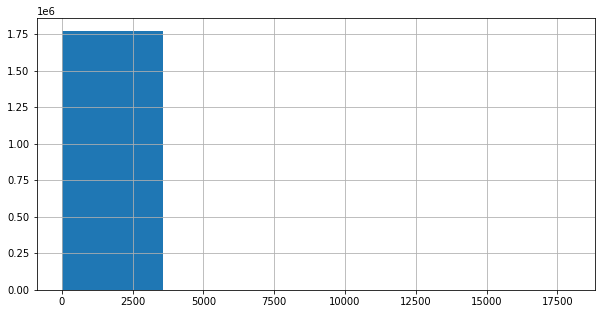

In [66]:
df['Claim Assembly Time Lag'].hist(bins=5, figsize=(10,5))

Now, choosing Highest Process as our target variable:

In [67]:
y = df['Highest Process']
X = df.drop(columns=['Highest Process'], axis=1)
y = pd.DataFrame(y)

In [68]:
y.value_counts()

Highest Process                
4A. HEARING - JUDGE                776947
2. ADMINISTRATIVE DETERMINATION    429030
4C. HEARING - SETTLEMENT           196709
3B. CONCILIATION - MEETING         176097
1.  NO RESOLUTIONS                  99864
4B. HEARING - APPEAL                95689
dtype: int64

Viewing the first 5 rows of the predictor features to be used in modeling:

In [69]:
X.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Carrier Type,Claim Injury Type,Closed Count,Current Claim Status,District Name,Gender,Hearing Count,Occupational Disease,Claim Assembly Time Lag
9909,44,N,Y,546.69,4A. SELF PRIVATE,3. MED ONLY,1,MOTION SET,NYC,M,0,N,68.0
16493,34,N,N,656.23,1A. PRIVATE,4. TEMPORARY,1,MOTION SET,ROCHESTER,M,0,N,6.0
19838,35,N,N,1261.77,1A. PRIVATE,4. TEMPORARY,0,MOTION SET,ALBANY,M,0,N,24.0
20487,25,N,Y,1000.00,2A. SIF,4. TEMPORARY,1,MOTION SET,NYC,M,0,N,23.0
20972,48,N,N,1126.77,3A. SELF PUBLIC,3. MED ONLY,1,MOTION SET,HAUPPAUGE,M,0,N,4.0


In [69]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split


# separate the numerical and categorical columns
numeric_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns





In [70]:
#X = X[numeric_cols + categorical_cols]
X = X[list(numeric_cols) + list(categorical_cols)]
#yf = df['Highest Process']

# create dummy variables for the categorical columns
X_dummies = pd.get_dummies(X[categorical_cols])

# concatenate the dummy variables with the numerical columns
X_processed = pd.concat([X[numeric_cols], X_dummies], axis=1)

# split the data into a train and test set, stratifying on the target variable
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify = y, test_size=0.2, random_state=42)



##### At this point, we would need to scale the dataset numerical values for better feature selection and modelling. Being a real-world dataset, the presence of outliers is inevitable. As a result, we would go with the Standard Scalar:

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### :We attempt to train a Decision Tree Classifier before we carry out any feature selection

In [72]:
X_train_scaled.shape

(1419468, 51)

In [123]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
clf_dt1 = DecisionTreeClassifier()

# Use stratified k-fold cross-validation to evaluate the classifier on the training data
scores_dt1 = cross_val_score(clf_dt1, X_train_scaled, y_train, cv=10)

# Calculate the mean and standard deviation of the scores
mean_score_dt1 = np.mean(scores_dt1)
std_dev_dt1 = np.std(scores_dt1)

# Train the classifier on the entire training set and test it on the test set
clf_dt1.fit(X_train_scaled, y_train)
test_score_dt1 = clf_dt1.score(X_test_scaled, y_test)


In [150]:
print(f"Accuracy of DecisionTreeClassifier before feature selection: {test_score_dt1: .4f}")

Accuracy of DecisionTreeClassifier before feature selection:  0.6352


In [155]:
for i in range(len(scores_dt1)):
  print(f'Accuracy of Fold {i+1}: {scores_dt1[i]: .4f}')

Accuracy of Fold 1:  0.6338
Accuracy of Fold 2:  0.6363
Accuracy of Fold 3:  0.6353
Accuracy of Fold 4:  0.6358
Accuracy of Fold 5:  0.6350
Accuracy of Fold 6:  0.6350
Accuracy of Fold 7:  0.6353
Accuracy of Fold 8:  0.6345
Accuracy of Fold 9:  0.6352
Accuracy of Fold 10:  0.6344


The accuracy is about 63%. This Decision Tree Classifier might be overfitting the training data, as it is generalizing poorly on the test set. It will not be concluded just yet, that is not a good model for our data. Accuracy is low. Going forward, we will attempt to improve this by:

- Using feature selection, to make sure that the features used by the model are ideal. We will achieve this using SelectKBest from Scikit-Learn and the univariate feature selection method, since we are dealing with categorical and numeric variables.

- Attempting to use other models, just in case the Decision Tree Classifier is not ideal for this dataset. We will use the Random Forest classifier and the Stochastic Gradient Descent.

- Thereafter, we will do some hyperparameter tuning using GridSearchCV, to estimate the best parameters to fit the above models.

- Finally, we will incorportate other performance metrics in assessing our results (making sure the majority class is not in favor)

#### Proceeding with feature selection, we will stick to the best 8  significant features, as depicted in the visualization that follows:

For the feature scoring, we will use the univariate feature selection with F-test, subsequently selecting the 15 most significant features.

In [73]:
from sklearn.feature_selection import SelectKBest, f_classif
# Flatten the y_train array into a 1d array

y_train = y_train.values
y_train = y_train.ravel()

# set K to equal the desired 15 features
selector = SelectKBest(f_classif, k=8)
selector.fit(X_train_scaled, y_train)

# Replace zeros in the pvalues_ array with a small non-zero value
selector.pvalues_[selector.pvalues_ == 0] = 1e-10

scores = -np.log10(selector.pvalues_)
scores /= scores.max()

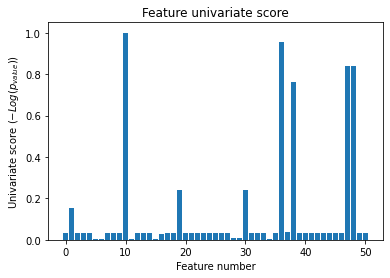

In [74]:
import matplotlib.pyplot as plt

# Create the X_indices array using the shape of the scores array
X_indices = np.arange(scores.shape[0])

# Create a new figure
plt.figure(1)
plt.clf()

# Plot the scores as a bar chart
plt.bar(X_indices, scores)

# Add a title, x-label, and y-label
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")

# Show the plot
plt.show()


In [140]:
print(scores)

[0.03306401 0.15330747 0.03306401 0.03306401 0.03306401 0.00287671
 0.00287671 0.03306401 0.03306401 0.03306401 1.         0.00594127
 0.03306401 0.03306401 0.03306401 0.00361644 0.02832264 0.03306401
 0.03306401 0.24092297 0.03306401 0.03306401 0.03306401 0.03306401
 0.03306401 0.03306401 0.03306401 0.03306401 0.00808887 0.00808887
 0.24092297 0.03306401 0.03306401 0.03306401 0.00339697 0.03306401
 0.95274798 0.04006895 0.76381784 0.03306401 0.03306401 0.03306401
 0.03306401 0.03306401 0.03306401 0.03306401 0.03306401 0.8387029
 0.8387029  0.03306401 0.03306401]


In [74]:
# Get the boolean array indicating which features were selected
selected = selector.get_support()

# Convert the X_train_scaled array into a DataFrame
X_train_scaled_df = pd.DataFrame(X_train)

# Get the column names of the X_train_scaled_df DataFrame
feature_names = X_train_scaled_df.columns.tolist()

# Print the names of the selected features
print("Selected features:")
for i, feature in enumerate(selected):
    if feature:
        print(f"{i}: {feature_names[i]}")


Selected features:
2: Closed Count
3: Hearing Count
7: Attorney/Representative_N
8: Attorney/Representative_Y
21: Claim Injury Type_3. MED ONLY
22: Claim Injury Type_4. TEMPORARY
23: Claim Injury Type_5. PPD SCH LOSS
24: Claim Injury Type_6. PPD NSL


In [143]:
selected

array([False, False,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

Selecting the top 8 features from the dataset:

In [75]:
# Select the top k features from the training and test datasets using the selector object
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

Now, we will re-train our Decision tree classifier using the selected features

In [145]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
clf_dt2 = DecisionTreeClassifier()

# Use stratified k-fold cross-validation to evaluate the classifier on the training data
scores_dt2 = cross_val_score(clf_dt2, X_train_selected, y_train, cv=10)

# Calculate the mean and standard deviation of the scores
mean_score_dt2 = np.mean(scores_dt2)
std_dev_dt2 = np.std(scores_dt2)

# Train the classifier on the entire training set and test it on the test set
clf_dt2.fit(X_train_selected, y_train)
test_score_dt2 = clf_dt2.score(X_test_selected, y_test)


In [146]:
test_score_dt2

0.7085648748266962

We observe that the accuracy has increased by about 7%, which is significant. However, we will continue to explore other ways to see if our model could do better on our test set.

In [147]:
mean_score_dt2

0.7087282005802173

We will move on to the Logistic Regression model. Trying out the Stochastic Gradient Descent:

In [154]:
from sklearn.linear_model import SGDClassifier

# Create an SGD logistic regression model
clf_sgd1 = SGDClassifier()

# Train the model on the training data
clf_sgd1.fit(X_train_selected, y_train)

# Test the model on the test data
y_pred_sgd1 = clf_sgd1.predict(X_test_selected)

# Evaluate the model 
accuracy_sgd1 = clf_sgd1.score(X_test_selected, y_test)
print(f"SGD  Classifier Accuracy of our model: {accuracy_sgd1:.4f}")

SGD  Classifier Accuracy of our model: 0.6505


In [153]:
# Calculate the training error
training_error_sgd = 1 - clf_sgd1.score(X_train_selected, y_train)

# Calculate the test error
test_error_sgd = 1 - clf_sgd1.score(X_test_selected, y_test)

print(f"SGD Classifier Training error: {training_error_sgd:.4f}")
print(f"SGD Classifier Test error: {test_error_sgd:.4f}")

SGD Classifier Training error: 0.3493
SGD Classifier Test error: 0.3495


We will attempt to improve this SGD Classifier by training using cross-validation:

In [157]:
# Create Model
clf_sgd2 = SGDClassifier()

# Train the model on the training data
clf_sgd2.fit(X_train_selected, y_train)

#Using cross validation:
scores_sgd2 = cross_val_score(clf_sgd2, X_train_selected, y_train, cv=10, scoring="accuracy")


In [158]:
#Printing the accuracies for each fold during cross-validation
for i in range(len(scores_sgd2)):
  print("Accuracy of Fold {}: {:.4f}".format(i+1, scores_sgd2[i]))

Accuracy of Fold 1: 0.6598
Accuracy of Fold 2: 0.6436
Accuracy of Fold 3: 0.6530
Accuracy of Fold 4: 0.6578
Accuracy of Fold 5: 0.6402
Accuracy of Fold 6: 0.6471
Accuracy of Fold 7: 0.6628
Accuracy of Fold 8: 0.6405
Accuracy of Fold 9: 0.6637
Accuracy of Fold 10: 0.6262


In [162]:
# Evaluate the model 
accuracy_sgd2 = clf_sgd2.score(X_test_selected, y_test)
print(f"SGD Classifier Accuracy of our model: {accuracy_sgd2:.4f}")

# Calculate the training error
training_error_sgd2 = 1 - clf_sgd1.score(X_train_selected, y_train)

# Calculate the test error
test_error_sgd2 = 1 - clf_sgd1.score(X_test_selected, y_test)

print(f"SGD Classifier Training error: {training_error_sgd2:.4f}")
print(f"SGD Classifier Test error: {test_error_sgd2:.4f}")

SGD Classifier Accuracy of our model: 0.6578
SGD Classifier Training error: 0.3493
SGD Classifier Test error: 0.3495


##### Accuracy not too good. We will attempt to use GridSearchCV to fine-tune the hyperparameters of the Decision tree model and the logistic regression model using the SGDClassifier class

### For the Decision Tree Model tuning:

In [164]:
from sklearn.model_selection import GridSearchCV

# Set up the grid search parameters
param_grid_dt2 = {
    "max_depth": [5, 7, 9, 11],  # try different values for max_depth
    "min_samples_split": [2, 4, 6, 8],  # try different values for min_samples_split
    "criterion": ["gini", "entropy"]  # try different values for criterion
}

# Set up the grid search. We will use cross validation also
grid_search_dt = GridSearchCV(clf_dt2, param_grid_dt2, cv=5, scoring="accuracy", n_jobs=-1)

# Fit the grid search to the training data we have scaled and selected
grid_search_dt.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9, 11],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

Best parameters, as selected by the Grid Search

In [165]:
# Use the best_params_ attribute of the GridSearchCV instance to get the best combination of hyperparameters
best_params_dt = grid_search_dt.best_params_
print(f"Best hyperparameters: {best_params_dt}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2}


In [166]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=9)

#### Using these hyperparameters to train a new Decision Tree Model:

In [174]:
from sklearn.metrics import accuracy_score

# Create a new DT model with the best hyperparameters
clf_dt_bp = DecisionTreeClassifier(**best_params_dt)

# Train the model on the training data
clf_dt_bp.fit(X_train_selected, y_train)

# Test the model on the test data
y_pred_dt_bp = clf_dt_bp.predict(X_test_selected)

# Evaluate the model's accuracy on the test data
accuracy_dt_bp = accuracy_score(y_test, y_pred_dt_bp)
print(f"Decision Tree Accuracy (after tuning): {accuracy_dt_bp:.4f}")

Decision Tree Accuracy (after tuning): 0.7089


#### Using these hyperparameters to train a new Stochastic Gradient Descent Model:

In [175]:
# Define the parameter grid for the hyperparameters to tune
param_grid_sgd = {
    "loss": ["log"],
    "penalty": ["l2", "l1"],
    "alpha": [0.0001, 0.001, 0.01],
}

# Create an instance of the GridSearchCV class
grid_search_sgd = GridSearchCV(clf_sgd2, param_grid_sgd, scoring="accuracy")

# Use the fit method of the GridSearchCV instance to fit the model to the training data
grid_search_sgd.fit(X_train_selected, y_train)

# Use the best_params_ attribute of the GridSearchCV instance to get the best combination of hyperparameters
best_params_sgd = grid_search_sgd.best_params_
print(f"Best hyperparameters: {best_params_sgd}")

Best hyperparameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}


In [180]:
grid_search_sgd.best_estimator_

SGDClassifier(loss='log', penalty='l1')

##### Using this best parameters to train a new model, we then evaluate the new model's performance metrics

In [177]:
# Create a new SGD logistic regression model with the best hyperparameters
clf_sgd_bp = SGDClassifier(**best_params_sgd)

# Train the model on the training data
clf_sgd_bp.fit(X_train_selected, y_train)

# Test the model on the test data
y_pred_sgd_bp = clf_sgd_bp.predict(X_test_selected)

# Evaluate the model's accuracy on the test data
accuracy_sgd_bp = accuracy_score(y_test, y_pred_sgd_bp)
print(f"SGD Accuracy (after tuning): {accuracy_sgd_bp:.4f}")


SGD Accuracy (after tuning): 0.6725


In [181]:
from sklearn.metrics import f1_score

# Compute the F1 score on the test data
f1 = f1_score(y_test, y_pred_sgd_bp, average = "micro")
f1_ = f1_score(y_test, y_pred_sgd_bp, average = None)
print(f"SGD F1 score (After tuning): {f1:.3f}")
#print(f"SGD F1 score for each class (After tuning): {f1_:.3f}")
f1_list = list(map("{:.3f}%".format,f1_)) #considering our multiclass prediction

SGD F1 score (After tuning): 0.673


In [ ]:
for i in range(len(f1_list)):
  print(f'{y_train[i]} - {f1_list[i]}')

### Considering other Performance Metrics (for DeisionTree Classifier)

In [ ]:
from sklearn.metrics import classification_report

# Predict the labels for the test data
y_pred_dt_bp = clf_dt_bp.predict(X_test_selected)

# Generate the classification report
report = classification_report(y_test, y_pred_dt_bp, target_names=target_names)
print(report)

### Considering other Performance Metrics (for SGD Classifier)

In [ ]:
# Predict the labels for the test data
y_pred_sgd_bp = clf_sgd_bp.predict(X_test_selected)

# Generate the classification report
report = classification_report(y_test, y_pred_dt_bp, target_names=target_names)
print(report)

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus

class_names = ["4C. HEARING - SETTLEMENT", "3B. CONCILIATION - MEETING", "4A. HEARING - JUDGE", "2. ADMINISTRATIVE DETERMINATION", "4B. HEARING - APPEAL" ]
feature_names = ["Closed Count", "Hearing Count", "Attorney/Representative_N", "Attorney/Representative_Y", "Carrier Type_3A. SELF PUBLIC", "Claim Injury Type_3. MED ONLY", "Claim Injury Type_4. TEMPORARY", "Claim Injury Type_5. PPD SCH LOSS", "Claim Injury Type_6. PPD NSL", "District Name_NYC" ]

# feature_names = [initial_list[i] for i, feature in enumerate(selected) if feature]

# Get the names of the selected features
selected_feature_names = [initial_list[i] for i, feature in enumerate(selected) if feature]

# Convert the decision tree object into a graph object
dot_data = export_graphviz(clf, out_file=None, feature_names=selected_feature_names, class_names=class_names)

# Create a graph object
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the graph
graph.write_png("decision_tree.png")

# Convert the decision tree object into a graph object
dot_data = export_graphviz(clf, out_file=None, feature_names=feature_names, class_names=class_names)

# Create a graph object
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the graph
graph.write_png("decision_tree.png")


In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(
  tree_clf,
  out_file=image_path("insurance_decsn.dot"),
  feature_names=iris.feature_names[2:],
  class_names=iris.target_names,
  rounded=True,
  filled=True
  )

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate the AUC score
auc = roc_auc_score(y_test, predictions)

# Get the false positive rate and true positive rate for each threshold
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Plot the AUROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print(confusion_matrix)


[[  4118  13552   2122      0      0      0]
 [  2484  80975   2267      0      0      0]
 [  1867  27773   5872      0      0      0]
 [     0      0      0 139473   1318  14665]
 [     0      0      0  12528   1458   5248]
 [     0      0      0  16115    803  22232]]


In [ ]:
from sklearn.naive_bayes import BernoulliNB

# Create the model
modelBNB = BernoulliNB()

# Train the model on the training data
modelBNB.fit(X_train_selected, y_train)

# Make predictions on the test data
predictions = modelBNB.predict(X_test_selected)

# Evaluate the model's performance
accuracy = modelBNB.score(X_test_selected, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.5772705497787922


##### We will model using the Random Forest Classifier, before its fine tuning

In [76]:
from sklearn.ensemble import RandomForestClassifier

clf_rf1 = RandomForestClassifier(n_estimators=100)

clf_rf1.fit(X_train_selected, y_train)

y_pred_rf = clf_rf1.predict(X_test_selected)

# Evaluate the model's performance
accuracy = clf_rf1.score(X_test_selected, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.7085000619948826


##### Evaluating the Classifier's performance:

In [78]:
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

                                 precision    recall  f1-score   support

             1.  NO RESOLUTIONS       0.43      0.20      0.28     19973
2. ADMINISTRATIVE DETERMINATION       0.67      0.93      0.78     85806
     3B. CONCILIATION - MEETING       0.53      0.17      0.26     35219
            4A. HEARING - JUDGE       0.81      0.92      0.86    155390
           4B. HEARING - APPEAL       0.42      0.08      0.13     19138
       4C. HEARING - SETTLEMENT       0.51      0.44      0.47     39342

                       accuracy                           0.71    354868
                      macro avg       0.56      0.46      0.46    354868
                   weighted avg       0.67      0.71      0.67    354868

[[  4055  12965   2953      0      0      0]
 [  3352  79995   2459      0      0      0]
 [  1945  27172   6102      0      0      0]
 [     0      0      0 142389   1139  11862]
 [     0      0      0  12854   1505   4779]
 [     0      0      0  20994    921  1742

Visualizing the confusion matrix: 

In [99]:
def plot_confusion_matrix(y_true, y_pred, target_names):
    """
    This function plots the confusion matrix.
    """
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(15,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=target_names, yticklabels=target_names,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#### ...for the Random Forest Classifier

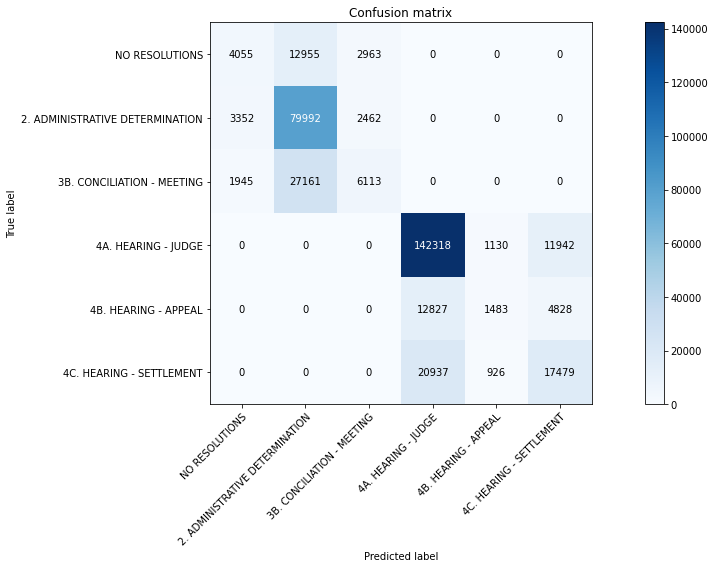

In [100]:
target_names = ["NO RESOLUTIONS", "2. ADMINISTRATIVE DETERMINATION", "3B. CONCILIATION - MEETING", "4A. HEARING - JUDGE", "4B. HEARING - APPEAL", "4C. HEARING - SETTLEMENT"]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, target_names)

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the categorical labels
le = LabelEncoder()
y_true = le.fit_transform(y_test)
y_score = le.transform(y_pred_rf)

# Convert y_score to a multi-dimensional array
y_score = np.repeat(y_score, len(y_true)).reshape(-1, len(y_true))


from sklearn.metrics import roc_auc_score

# Compute the AUC for each class
aucs = []
for i, class_ in enumerate(classes):
    auc = roc_auc_score(y_true == i, y_score[:, i])
    aucs.append(auc)

# Plot the ROC curves
for i, class_ in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_score[i])
    plt.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(class_, aucs[:, i]))

plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## PRELIMINARY REPORTS

##### SGD

In [132]:
from sklearn.metrics import classification_report

# evaluate the model
report = classification_report(y_test, y_pred_sgd)
print(report)

                                 precision    recall  f1-score   support

             1.  NO RESOLUTIONS       0.40      0.00      0.01     19916
2. ADMINISTRATIVE DETERMINATION       0.67      0.91      0.77     85565
     3B. CONCILIATION - MEETING       0.76      0.03      0.06     35381
            4A. HEARING - JUDGE       0.71      0.94      0.81    155673
           4B. HEARING - APPEAL       0.46      0.04      0.07     19145
       4C. HEARING - SETTLEMENT       0.58      0.42      0.49     39188

                       accuracy                           0.68    354868
                      macro avg       0.60      0.39      0.37    354868
                   weighted avg       0.66      0.68      0.60    354868



#### We will proceed to analysing the Classification report for Random Forest (without regularization)

In [135]:
from sklearn.metrics import classification_report

# evaluate the model
report = classification_report(y_test, y_pred_rf)
print(report)

                                 precision    recall  f1-score   support

             1.  NO RESOLUTIONS       0.47      0.21      0.29     19916
2. ADMINISTRATIVE DETERMINATION       0.67      0.92      0.77     85565
     3B. CONCILIATION - MEETING       0.52      0.21      0.30     35381
            4A. HEARING - JUDGE       0.83      0.89      0.86    155673
           4B. HEARING - APPEAL       0.31      0.16      0.21     19145
       4C. HEARING - SETTLEMENT       0.55      0.52      0.53     39188

                       accuracy                           0.71    354868
                      macro avg       0.56      0.48      0.49    354868
                   weighted avg       0.68      0.71      0.68    354868



Visualizing the above:

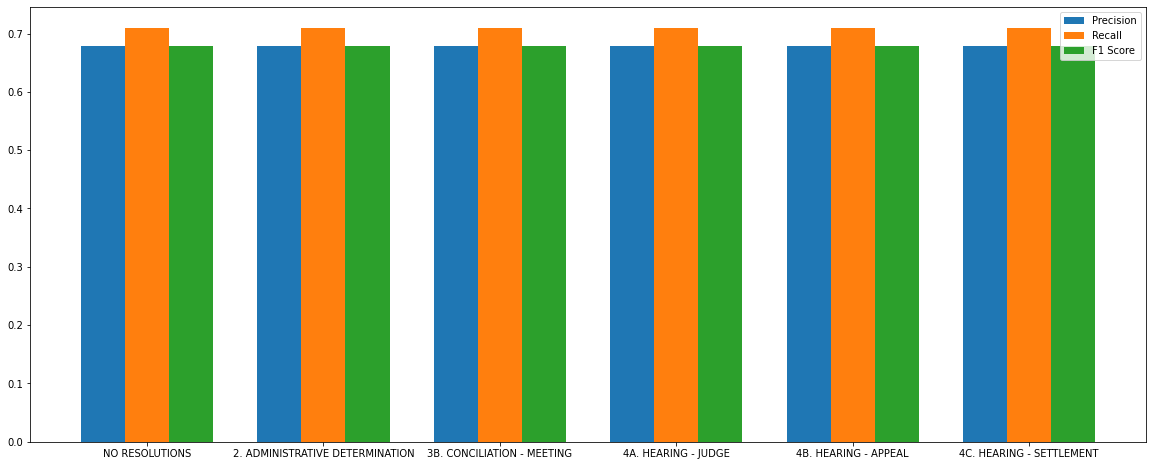

In [143]:
# Extract the precision, recall, and F1 score values from the classification report
#report = classification_report(y_test, y_pred_rf, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

target_names = ["NO RESOLUTIONS", "2. ADMINISTRATIVE DETERMINATION", "3B. CONCILIATION - MEETING", "4A. HEARING - JUDGE", "4B. HEARING - APPEAL", "4C. HEARING - SETTLEMENT"]

# Set up the bar chart
x = np.arange(len(target_names))  # the x-axis will have one tick for each class
width = 0.25  

fig, ax = plt.subplots(figsize=(20,8))

# Plot the precision values
precision_bar = ax.bar(x - width, precision, width, label="Precision")
# Plot the recall values
recall_bar = ax.bar(x, recall, width, label="Recall")
# Plot the F1 score values
f1_bar = ax.bar(x + width, f1_score, width, label="F1 Score")

# Add the class labels to the x-axis
ax.set_xticks(x)
ax.set_xticklabels(target_names)

# Add a legend
ax.legend()

# Show the plot
plt.show()


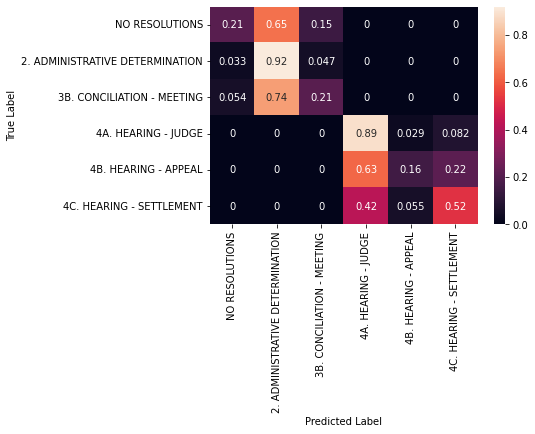

In [145]:
from sklearn.metrics import confusion_matrix


# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Set up the heatmap
sns.heatmap(confusion_matrix, annot=True, xticklabels=target_names, yticklabels=target_names)

# Add the x-axis and y-axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()
